# Modèle de Gray-Scott

&nbsp;

<center>**Loic Gouarin**</center>
<center>11 juillet 2017</center>

&nbsp;

Le modèle de Gray-Scott permet de simuler deux espèces chimiques $A$ et $B$ qui réagissent entre elles et qui diffusent.

Le modèle mathématique est assez simple

$$
\begin{array}{l}
\frac{\partial A}{\partial t} = D_A \Delta A - AB^2 + f(1-A) \\
\frac{\partial B}{\partial t} = D_B \Delta B + AB^2 - (k+f)B
\end{array}
$$

On peut approcher le laplacien par un schéma aux différences finies à 5 points. 

$$
\Delta A_{i,j} \approx A_{i,j-1} + A_{i-1,j} -4A_{i,j} + A_{i+1, j} + A_{i, j+1}
$$

La dérivée en temps peut être approchée par un schéma d'Euler explicite.

## Initialisation

$A$ vaut $1$ partout et $B$ vaut $0$ partout sauf à un endroit du domaine où on met $0.25$ pour $B$ et $0.5$ pour A. Cet endroit sera un carré situé au centre du domaine $[0, 1]\times[0,1]$ et de coté $0.2$.

Ecrivez la fonction **init** qui prend en paramètre le nombre de points dans chaque direction et qui initialise $A$ et $B$.

Le prototype de la fonction est le suivant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

In [2]:
def init(n):
    """
    Initialise deux matrices A et B de taille (n+2,n+2)de la manière suivante
    
    A vaut 1 et B vaut 0 partout sauf dans le carré situé au centre du domaine [0,1]×[0,1]  
    et de coté  0.2 où A = 0.5 et B = 0.25. 
    
    Paramètres
    ----------
    
    n : un entier représentant le nombre de points intérieurs
    
    Sorties
    -------
    
    A et B
    
    """
    A = np.ones((n+2,n+2))
    B = np.zeros((n+2,n+2))

    x = np.linspace(0, 1, n+2)
    y = np.linspace(0, 1, n+2)[:, np.newaxis]

    maskx = np.logical_and(.4<x, x<.6)
    masky = np.logical_and(.4<y, y<.6)
    mask = np.logical_and(maskx, masky)
    
    A[mask] = 0.50
    B[mask] = 0.25
    
    return A, B

## Conditions périodiques

On supposera dans la suite que nous aurons des conditions périodiques au bords.

Ecrivez une fonction **period_fonc** qui prend en paramètre un tableau 2d $u$ et qui lui applique les conditions périodiques. 

Le prototype est le suivant

In [3]:
def periodic_cond(u):
    """
    Applique les conditions périodiques au tableau 2d u
    """
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -2]
    u[:, -1] = u[:, 1]

## Laplacien

Ecrivez une fonction **laplacien** qui prend en paramètre un tableau 2d $u$ de taille $(n+2, n+2)$ et qui retourne le laplacien pour les points intérieurs (la taille est $(n,n)$).

Le prototype est le suivant

In [4]:
def laplacian(u):
    """
    Applique le laplacien 2d au tableau u et le renvoie.
    """
    return (                  u[ :-2, 1:-1] +
             u[1:-1, :-2] - 4*u[1:-1, 1:-1] + u[1:-1, 2:] +
                          +   u[2:  , 1:-1] )

## Gray-Scott

Ecrivez la fonction **grayscott** qui prend en paramètres d'entrée $A$, $B$, $D_A$, $D_B$, $f$ et $k$ et qui applique le modèle de Gray-Scott. On prendra un schéma d'Euler explicite pour l'intégration en temps avec un pas égal à $1$.

Le prototype est le suivant

In [5]:
def grayscott(A, B, Da, Db, f, k):
    """
    Applique le modèle de Gray-Scott aux matrices A et B.
    
    A la fin de l'intégration en temps, on applique les conditions 
    périodiques sur les deux matrices.
    """
    a, b = A[1:-1,1:-1], B[1:-1,1:-1]

    La = laplacian(A)
    Lb = laplacian(B)

    abb = a*b*b
    a += Da*La - abb + f*(1 - a)
    b += Db*Lb + abb - (f + k)*b

    periodic_cond(A)
    periodic_cond(B)

## Représentation graphique

Nous utiliserons les données suivantes.

In [6]:
Da, Db = .1, .05
#f, k = 0.0367, 0.0649 
f, k = 0.0545, 0.062
#f, k = 0.018, 0.050
#f, k = 0.050, 0.065
#f, k = 0.035, 0.060

Ecrivez une fonction **animate** qui exécute quarante fois la fonction **grayscott** et qui met à jour les données d'un **imshow** que l'on aura initialisé.

In [7]:
def animate(i):
    for t in range(40):
        grayscott(A, B, Da, Db, f, k)
    image.set_array(B)
    #return image,

Testez votre fonction avec le script suivant.

<IPython.core.display.Javascript object>


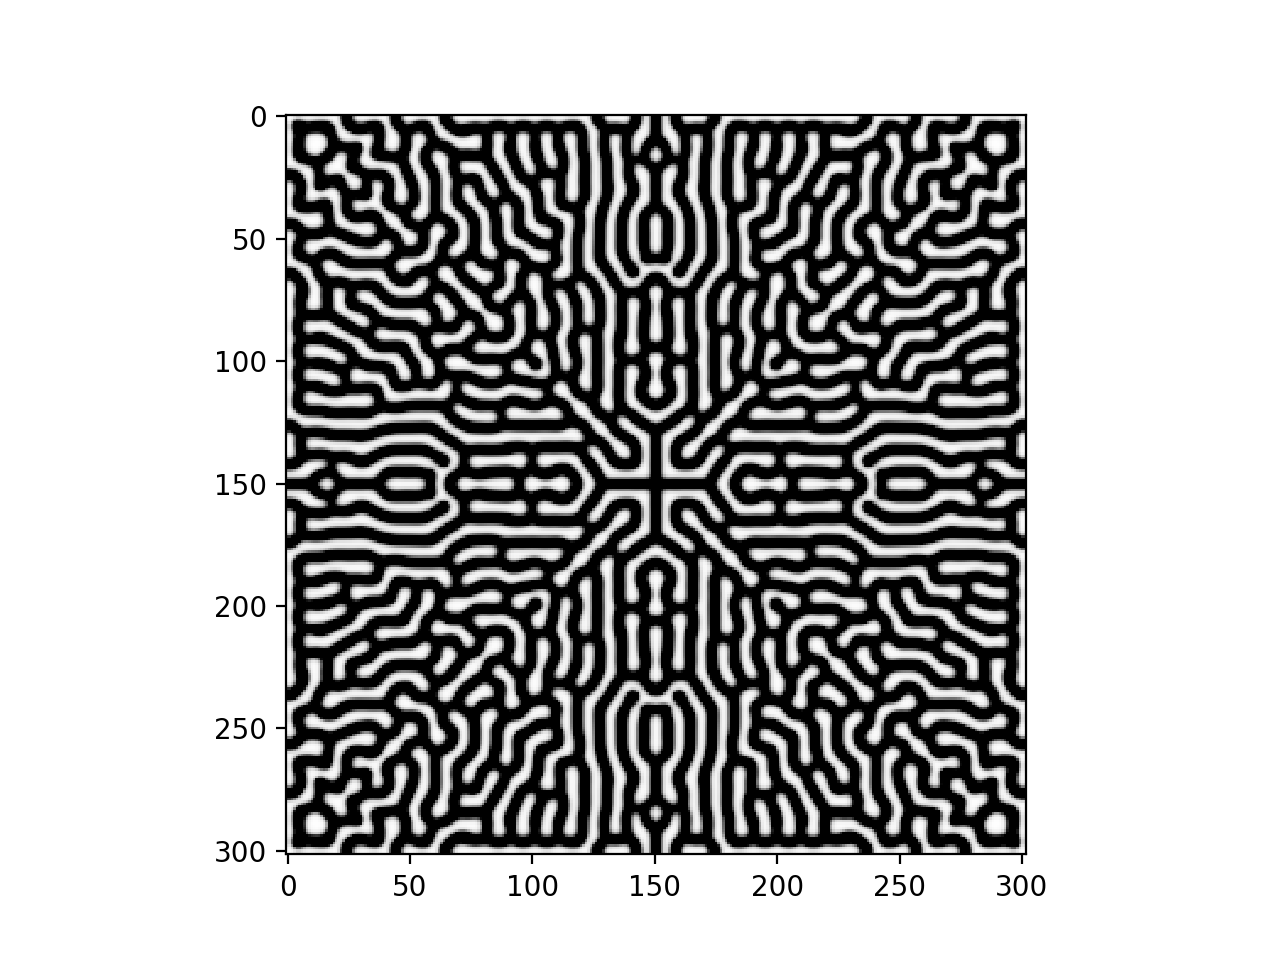

In [8]:
%matplotlib nbagg

fig = plt.figure()

A, B = init(300)

image = plt.imshow(B,  cmap = cm.Greys)

anim = animation.FuncAnimation(fig, animate, frames=500, interval=10)
#anim.save('grayscott.mp4', fps=20, dpi=300)

plt.show()

In [10]:
from tqdm import tqdm_notebook as tqdm
from PIL import Image
A, B = init(300)

def create_image():
    global A, B
    for t in range(40):
        grayscott(A, B, Da, Db, f, k)
    B_scaled = np.uint8(255*(B-B.min()) / (B.max()-B.min()))
    return B_scaled

def create_frames(n):

    return [create_image() for i in tqdm(range(n))]
    
frames = create_frames(500)

In [13]:
from ipywidgets import interact, IntSlider

def display_image(x):
    
    return Image.fromarray(x)

def display_sequence(iframe):
    
    return display_image(frames[iframe])
    
interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

interactive(children=(IntSlider(value=0, description='iframe', max=499), Output()), _dom_classes=('widget-inte…

<function __main__.display_sequence(iframe)>

In [14]:
import imageio
frames_scaled = [np.uint8(255 * frame) for frame in frames]
imageio.mimsave('movie.gif', frames_scaled, format='gif', fps=60)

![grayscott](movie.gif "grayscott")

In [17]:
from IPython.display import display
from ipywidgets import Button, FloatSlider, HBox, Label

caption = Label(value='f:')

f_slider = FloatSlider(min=0.010, max=0.050, step=0.0001, 
                     value=0.0545, description='f:')
k_slider = FloatSlider(min=0.050, max=0.070, step=0.0001,
                     value=0.062, description='k:')

def handle_slider_change(change):
    caption.value = f' f = {f_slider.value}, k = {k_slider.value}'
    

f_slider.observe(handle_slider_change, names='value')
k_slider.observe(handle_slider_change, names='value')

button = Button(description="Run")
display(button)

def run_button_clicked(b):
    print("Run")
    f, k = f_slider.value, k_slider.value
    A, B = init(300)
    frames = create_frames(500)
    return interact(display_sequence, 
         iframe=IntSlider(min=0,
                          max=len(frames)-1,
                          step=1,
                          value=0, 
                          continuous_update=True))

display(f_slider, k_slider, caption )

button.on_click(run_button_clicked)


Button(description='Run', style=ButtonStyle())

FloatSlider(value=0.05, description='f:', max=0.05, min=0.01, step=0.0001)

FloatSlider(value=0.062, description='k:', max=0.07, min=0.05, step=0.0001)

Label(value='f:')

Run


interactive(children=(IntSlider(value=0, description='iframe', max=499), Output()), _dom_classes=('widget-inte…

Run


interactive(children=(IntSlider(value=0, description='iframe', max=499), Output()), _dom_classes=('widget-inte…

Run


interactive(children=(IntSlider(value=0, description='iframe', max=499), Output()), _dom_classes=('widget-inte…

In [ ]:
import imageio
frames_scaled = [np.uint8(255 * frame) for frame in frames]
imageio.mimsave('movie.gif', frames_scaled, format='gif', fps=60)

In [18]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("../style/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>